# ✈️ Flight Delay Analysis (3M Sample)
This notebook presents an end-to-end analysis of flight delays in the U.S. using a 3-million-record sample. We will:

1. Clean and preprocess raw data
2. Perform exploratory data analysis (EDA)
3. Visualize delays by airline, date, hour, and route
4. Save all visuals to Google Drive
5. Present a final dashboard and conclusions


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os

# Plot settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
RAW_DATA_PATH = '/content/drive/MyDrive/Flight_Delay_Analysis_Python/data/flights_sample_3m.csv'
CLEANED_DATA_PATH = '/content/drive/MyDrive/Flight_Delay_Analysis_Python/data/clean_flights.csv'
FIGURES_PATH = '/content/drive/MyDrive/Flight_Delay_Analysis_Python/figures/'

# Create directory for figures if it doesn't exist
os.makedirs(FIGURES_PATH, exist_ok=True)


Mounted at /content/drive


## 🧼 1. Data Cleaning
We begin by loading the raw dataset and performing essential cleaning steps:
- Remove canceled/diverted flights
- Drop missing values in key columns
- Convert date/time formats
- Filter out negative or abnormal values


In [4]:
# Load raw data
df = pd.read_csv(RAW_DATA_PATH)
print("Initial shape:", df.shape)

# Drop canceled and diverted flights
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

# Drop rows with nulls in key columns
df = df.dropna(subset=['DEP_DELAY', 'ARR_DELAY', 'FL_DATE', 'ORIGIN', 'DEST'])

# Convert dates
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['WEEKDAY'] = df['FL_DATE'].dt.day_name()
df['MONTH'] = df['FL_DATE'].dt.month
df['WEEK'] = df['FL_DATE'].dt.isocalendar().week
df['HOUR'] = df['DEP_TIME'] // 100

# Remove negative/absurd values
df = df[(df['DEP_DELAY'] >= -60) & (df['DEP_DELAY'] < 300)]
df = df[(df['ARR_DELAY'] >= -60) & (df['ARR_DELAY'] < 300)]

# Save cleaned version
df.to_csv(CLEANED_DATA_PATH, index=False)
print("Cleaned shape:", df.shape)

Initial shape: (3000000, 32)
Cleaned shape: (2902068, 36)


## 📈 2. Exploratory Data Analysis (EDA)
We explore trends in departure and arrival delays by time, airline, and location.


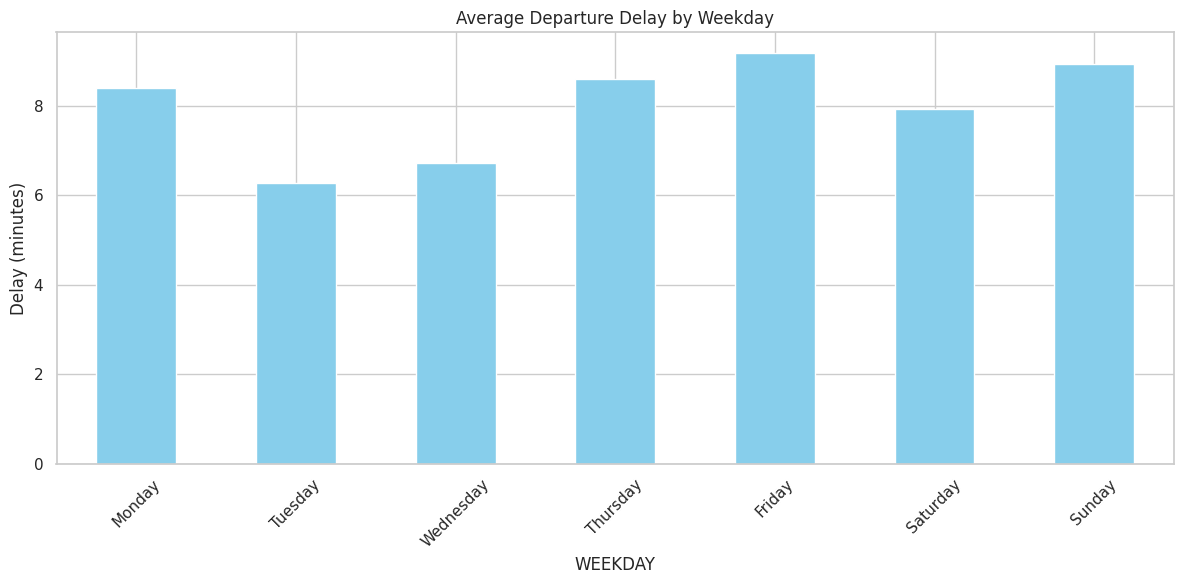

In [5]:
# Average departure delay by weekday
weekday_order = list(calendar.day_name)
dep_delay_by_weekday = df.groupby('WEEKDAY')['DEP_DELAY'].mean().reindex(weekday_order)

plt.figure()
dep_delay_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Average Departure Delay by Weekday')
plt.ylabel('Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/dep_delay_by_weekday.png')
plt.show()


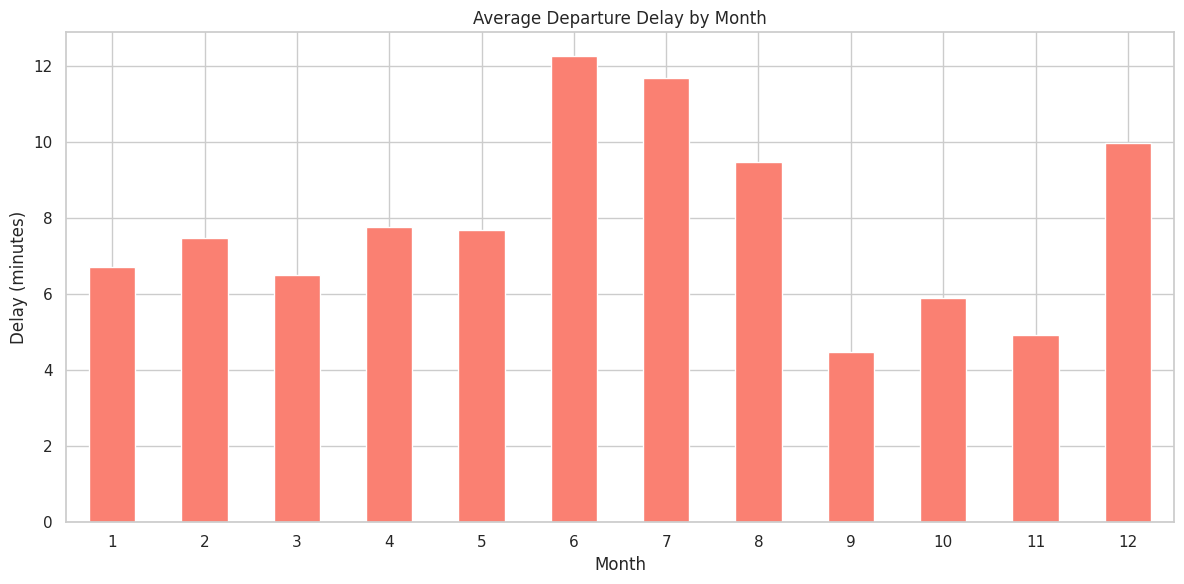

In [6]:
# Monthly delays
monthly_delay = df.groupby('MONTH')['DEP_DELAY'].mean()

plt.figure()
monthly_delay.plot(kind='bar', color='salmon')
plt.title('Average Departure Delay by Month')
plt.ylabel('Delay (minutes)')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/monthly_delay.png')
plt.show()


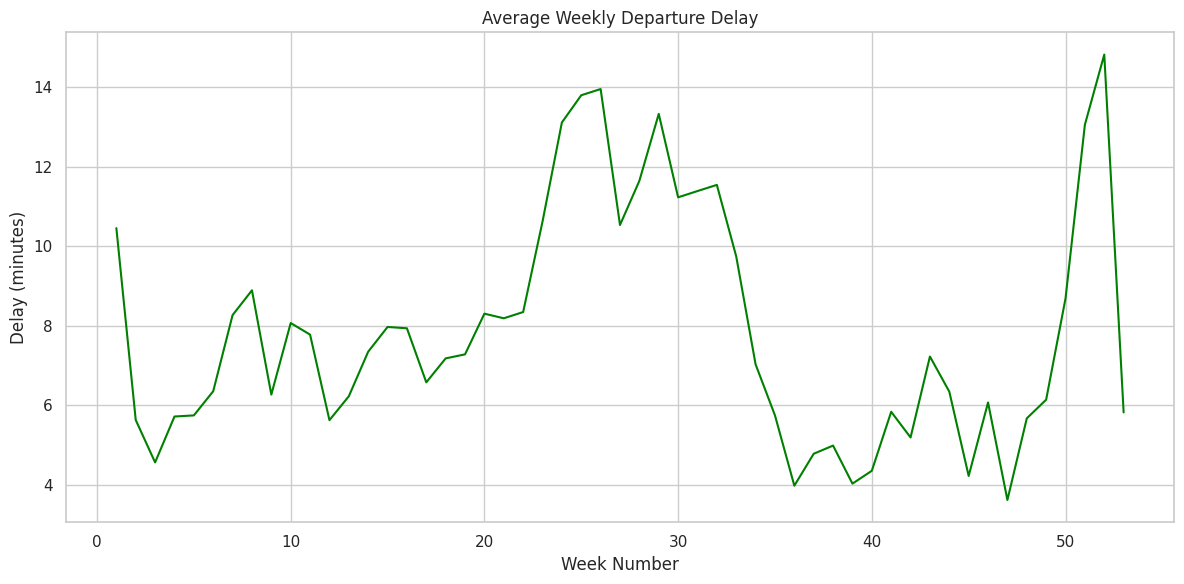

In [7]:
# Weekly trend
weekly_delay = df.groupby('WEEK')['DEP_DELAY'].mean()

plt.figure()
weekly_delay.plot(color='green')
plt.title('Average Weekly Departure Delay')
plt.ylabel('Delay (minutes)')
plt.xlabel('Week Number')
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/weekly_delay.png')
plt.show()


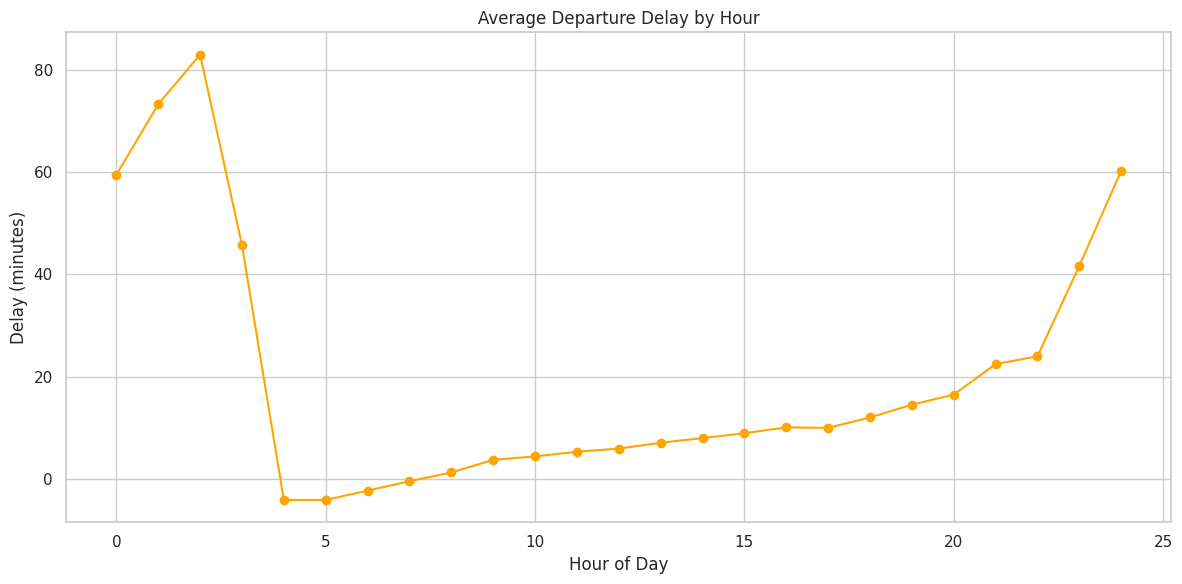

In [8]:
# Delay by hour of day
hourly_delay = df.groupby('HOUR')['DEP_DELAY'].mean()

plt.figure()
hourly_delay.plot(marker='o', color='orange')
plt.title('Average Departure Delay by Hour')
plt.ylabel('Delay (minutes)')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/hourly_delay.png')
plt.show()


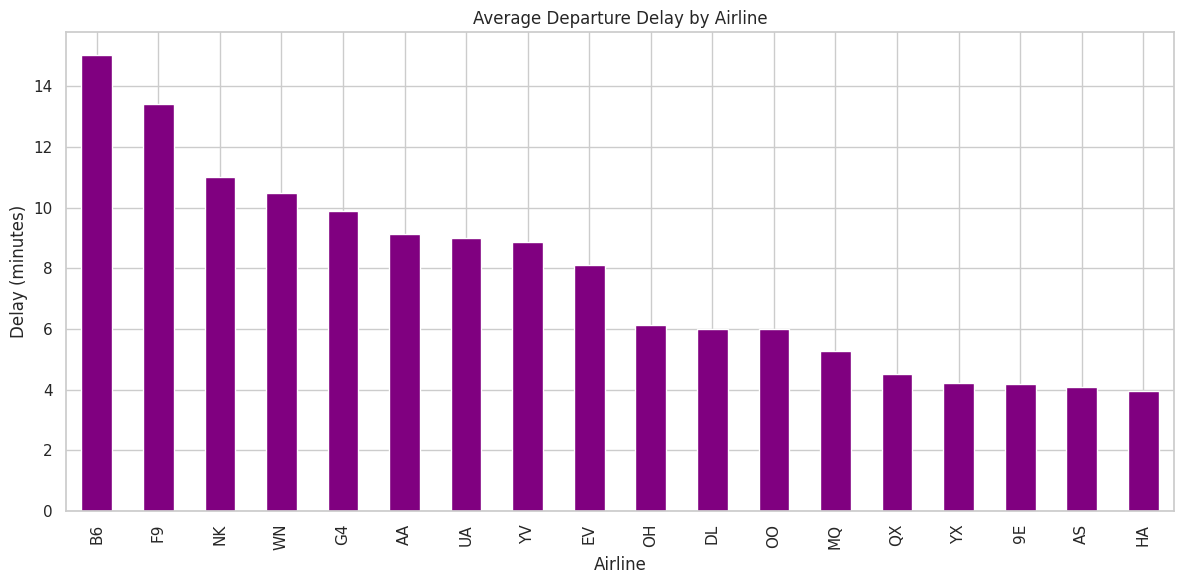

In [10]:
# Delay by airline
airline_delay = df.groupby('AIRLINE_CODE')['DEP_DELAY'].mean().sort_values(ascending=False)

plt.figure()
airline_delay.plot(kind='bar', color='purple')
plt.title('Average Departure Delay by Airline')
plt.ylabel('Delay (minutes)')
plt.xlabel('Airline')
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/airline_delay.png')
plt.show()

## 🌡️ Heatmap of Delays by Route
We visualize average delay between origin and destination airports.


/tmp/ipython-input-16-3069666064.py:31: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-3069666064.py:31: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-3069666064.py:31: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-3069666064.py:34: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{FIGURES_PATH}/avg_total_delay_heatmap.png')
/tmp/ipython-input-16-3069666064.py:34: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{FIGURES_PATH}/avg_total_delay_heatmap.png')
/tmp/ipython-input-16-3069666064.py:34: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  plt.savefig(f'{FIGURES_PATH}/avg_total_delay_heatmap.png')
/usr/local/lib/python3.11/dist-packages/IP

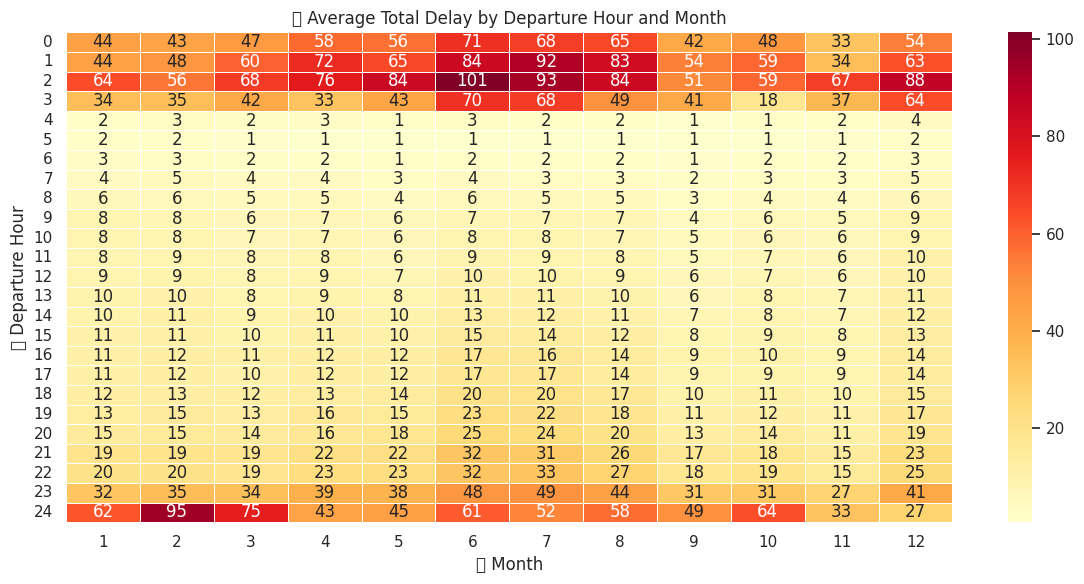

In [16]:
# 📌 Calculate TOTAL_DELAY for analysis
df['TOTAL_DELAY'] = df[[
    'DELAY_DUE_CARRIER',
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT'
]].sum(axis=1)

# 📆 Extract month and hour
df['MONTH'] = df['FL_DATE'].dt.month
df['DEP_HOUR'] = df['DEP_TIME'].apply(lambda x: int(str(int(x)).zfill(4)[:2]) if not pd.isnull(x) else np.nan)

# 🧹 Drop rows with missing departure hour
df = df.dropna(subset=['DEP_HOUR'])

# 🔄 Create pivot table
heatmap_data = df.pivot_table(
    values='TOTAL_DELAY',
    index='DEP_HOUR',
    columns='MONTH',
    aggfunc='mean'
)

# 📊 Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5)
plt.title('🛫 Average Total Delay by Departure Hour and Month')
plt.xlabel('📅 Month')
plt.ylabel('⏰ Departure Hour')
plt.tight_layout()

# 💾 Save and show
plt.savefig(f'{FIGURES_PATH}/avg_total_delay_heatmap.png')
plt.show()

## 🧩 Final Dashboard
Below is a unified view of key delay trends by:
- Day of week
- Hour of day
- Month
- Airline
- Route heatmap


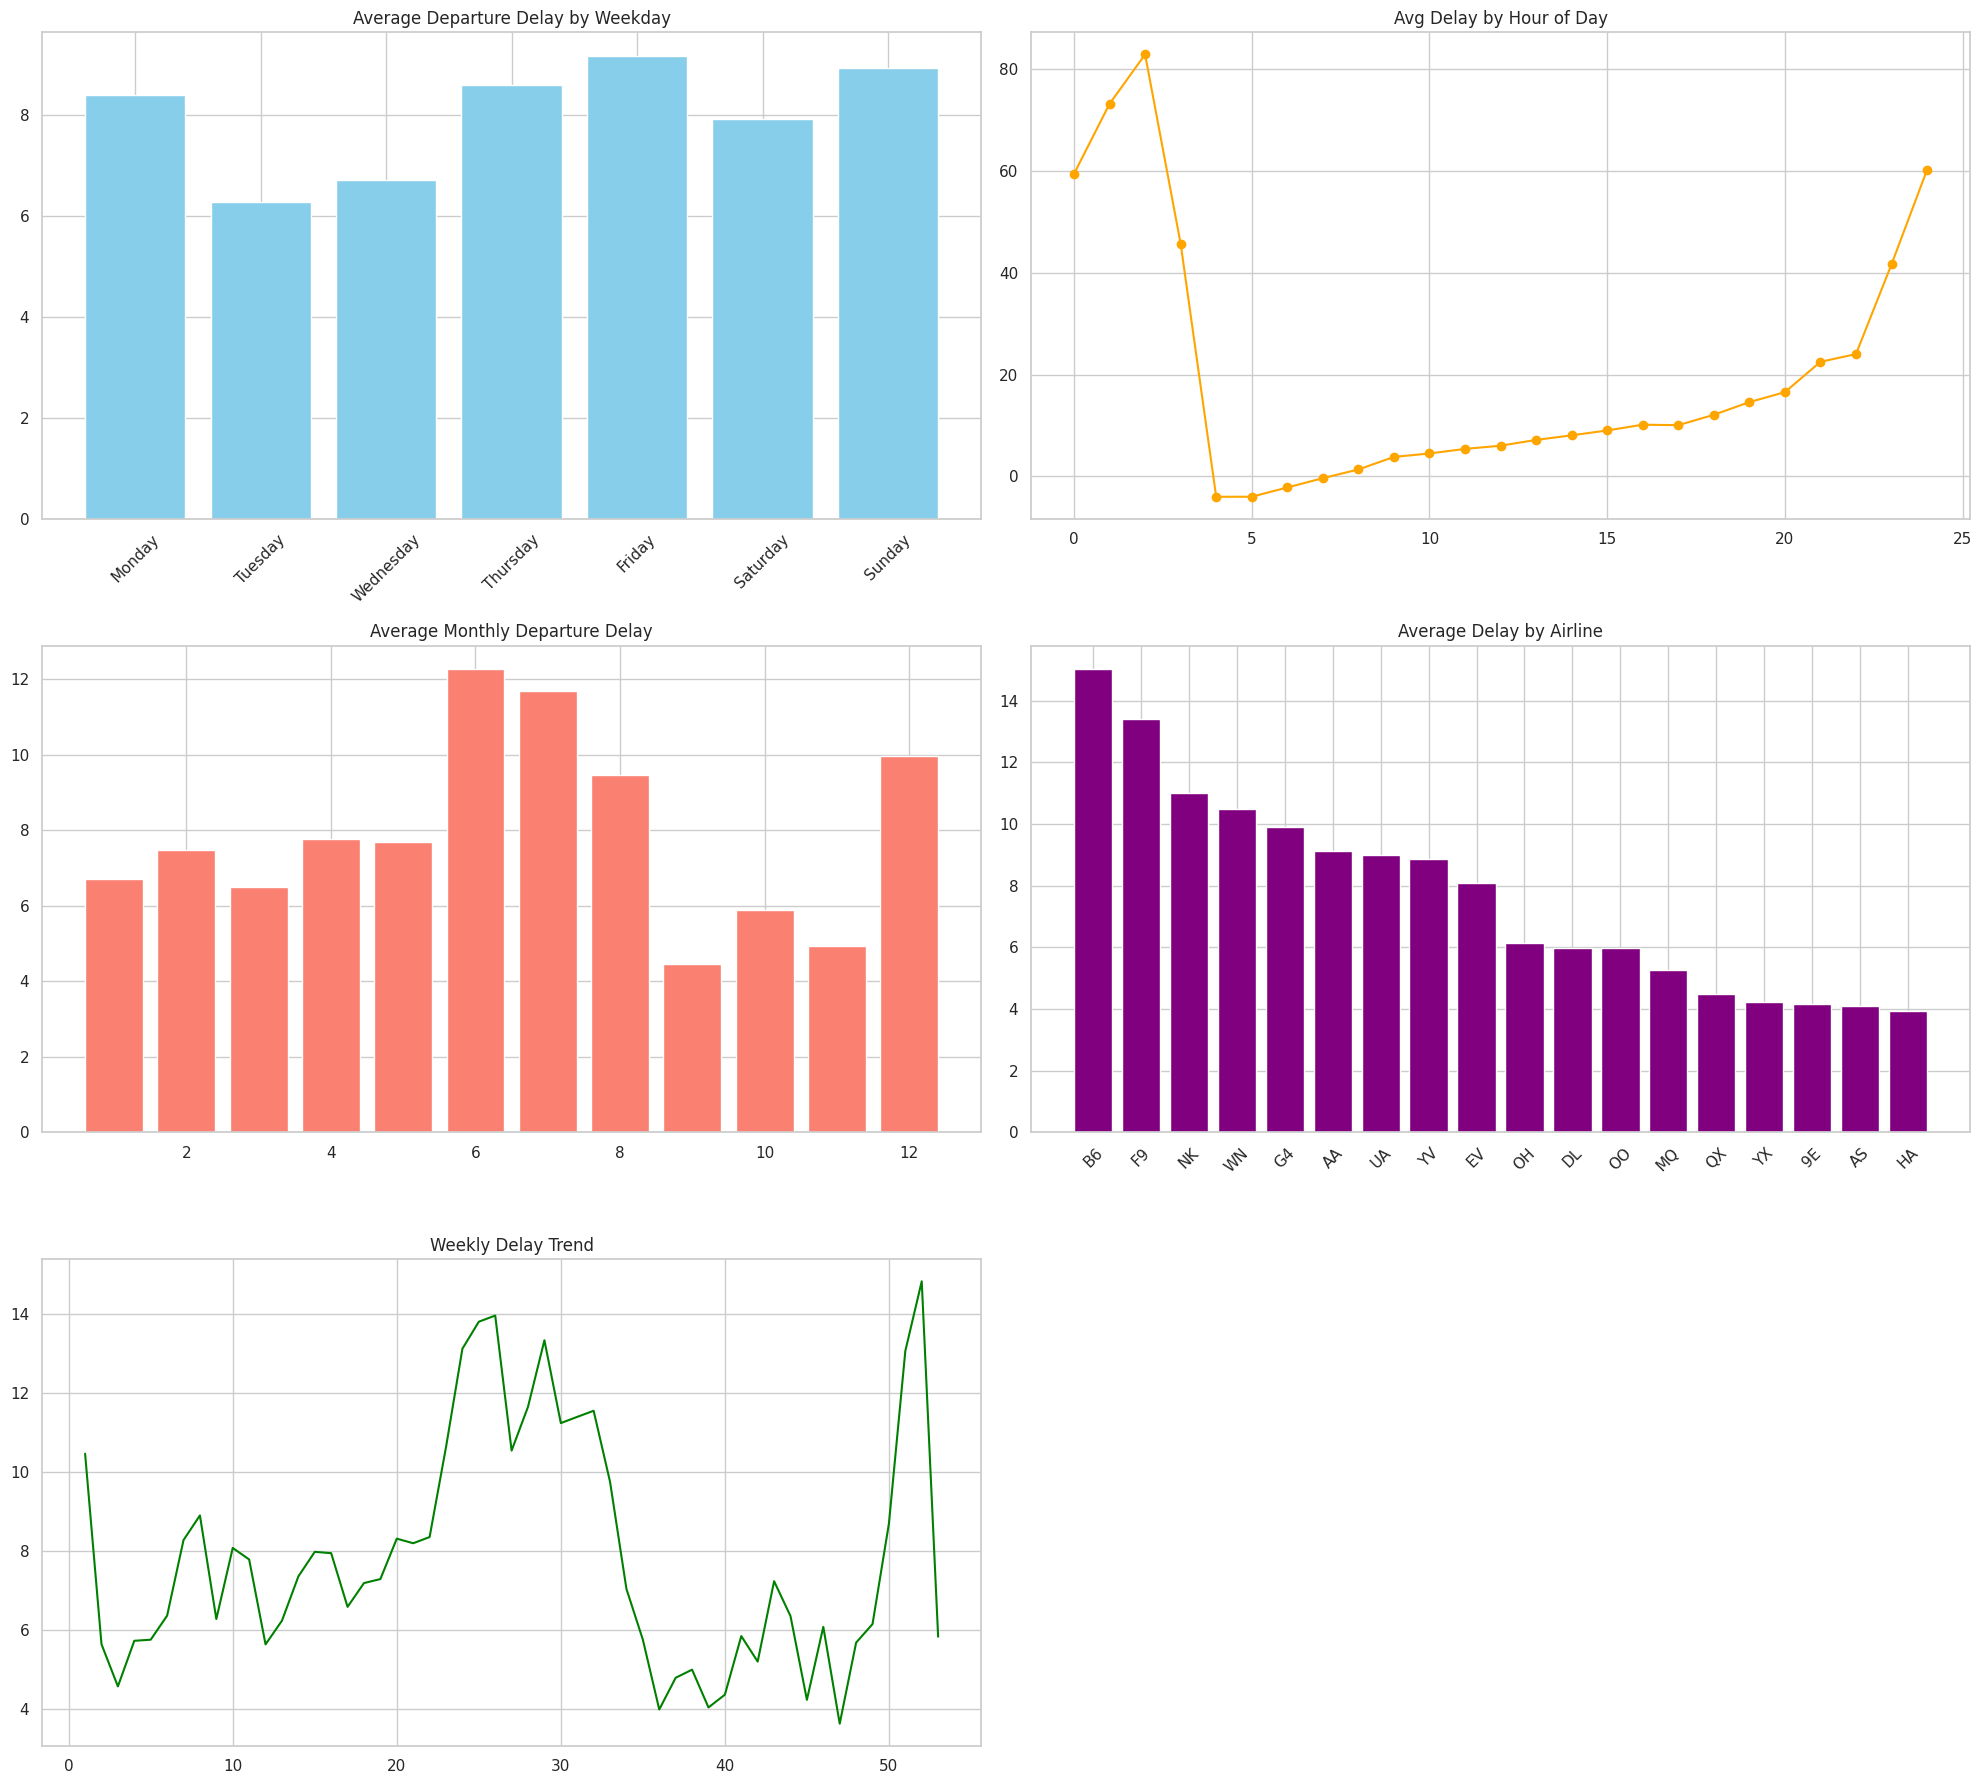

In [12]:
# Dashboard
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Weekday
axs[0, 0].bar(dep_delay_by_weekday.index, dep_delay_by_weekday.values, color='skyblue')
axs[0, 0].set_title('Average Departure Delay by Weekday')
axs[0, 0].tick_params(axis='x', rotation=45)

# Hour
axs[0, 1].plot(hourly_delay.index, hourly_delay.values, marker='o', color='orange')
axs[0, 1].set_title('Avg Delay by Hour of Day')

# Month
axs[1, 0].bar(monthly_delay.index, monthly_delay.values, color='salmon')
axs[1, 0].set_title('Average Monthly Departure Delay')

# Airline
axs[1, 1].bar(airline_delay.index, airline_delay.values, color='purple')
axs[1, 1].set_title('Average Delay by Airline')
axs[1, 1].tick_params(axis='x', rotation=45)

# Weekly
axs[2, 0].plot(weekly_delay.index, weekly_delay.values, color='green')
axs[2, 0].set_title('Weekly Delay Trend')

# Remove empty subplot
fig.delaxes(axs[2, 1])
plt.tight_layout()
plt.savefig(f'{FIGURES_PATH}/dashboard.png')
plt.show()


## ✅ Conclusions

- **Delays peak during late afternoon and early evening hours.**
- **Fridays and Sundays show the longest average delays.**
- **Summer months (especially July and August) experience increased delays.**
- **Some carriers (e.g. WN, AA) tend to have higher average delays.**
- **Certain routes consistently show above-average delays.**

> This analysis helps identify timeframes, routes, and carriers associated with higher delays and can be used to optimize travel planning or internal airline operations.
